In [1]:
Sys.setlocale(category = "LC_ALL", locale = "en_US.UTF-8")

[1] "en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/C"

# Dependencies

In [2]:
pacman::p_load(dplyr, ggplot2, ggbeeswarm, ggpubr, ggsignif, cowplot, lsmeans)

# Functions

In [1]:
source("/Users/anabbi/git/ped_CapTCRseq/R/ggplot2_theme.R")
source("/Users/anabbi/git/ped_CapTCRseq/R/color_schemes.R")
source("/Users/anabbi/git/ped_CapTCRseq/R/Misc_functions.R")

In [5]:
lsmeans_df.fx <- function(df, mycols, cancergrp) {
    grp_df <- df[df$cancergroup == cancergrp, ]
    myformula <- as.formula(paste0(mycols[1], " ~ cycle + Age + (1 | Patient)"))
    myfit <- lme4::lmer(myformula, data = grp_df) # keep cycle as categorical
    lsm <- lsmeans(myfit, "cycle")
    mylsm_grp <- summary(lsm)
    mylsm_grp$cancergroup <- cancergrp # has to be same as original df
    mylsm_grp$marker <- gsub("`", "", mycols[1])

    myctrt_grp <- as.data.frame(lsmeans::contrast(lsm, "trt.vs.ctrl", ref = "X01"))
    myctrt_grp$cancergroup <- cancergrp
    myctrt_grp$marker <- gsub("`", "", mycols[1])

    for (i in mycols[2:length(mycols)]) {
        print(i)
        myformula <- as.formula(paste0(i, " ~ cycle + Age + (1 | Patient)"))
        myfit <- lme4::lmer(myformula, data = grp_df)
        lsm <- lsmeans(myfit, "cycle")
        myctrt <- as.data.frame(lsmeans::contrast(lsm, "trt.vs.ctrl", ref = "X01"))
        myctrt$cancergroup <- cancergrp
        myctrt$marker <- gsub("`", "", i)
        myctrt_grp <- rbind(myctrt_grp, myctrt)

        mylsm <- summary(lsm)
        mylsm$cancergroup <- cancergrp
        mylsm$marker <- gsub("`", "", i)
        mylsm_grp <- rbind(mylsm_grp, mylsm)
    }

    mylsm_grp$Cycle <- as.character(mylsm_grp$cycle)
    mylsm_grp$Cycle <- as.numeric(gsub("X0", "", mylsm_grp$Cycle))

    myctrt_grp$Cycle <- as.character(gsub(" - X01", "", myctrt_grp$contrast))
    myctrt_grp$Cycle <- gsub("X0", "", myctrt_grp$Cycle)

    mylsm_grp$marker <- factor(mylsm_grp$marker, levels = gsub("`", "", mycols))
    myctrt_grp$marker <- factor(myctrt_grp$marker, levels = gsub("`", "", mycols))

    return(list(mylsm_grp, myctrt_grp))
}


In [6]:
set.seed(111)
baseplot.fx <- function(mydf, x, y, fill, clr, colpal) {
    p1 <- ggplot(mydf, aes(x = factor(eval(parse(text = x))), y = eval(parse(text = y)), color = eval(parse(text = clr)), fill = eval(parse(text = fill)))) +
        geom_jitter(width = 0.1, height = 0.1, alpha = 0.2) +
        geom_boxplot(outlier.shape = NA, alpha = 0.1) +
        # geom_smooth(method = "loess", se = TRUE, aes(group = 1), color = "black", fill = "grey") +
        myplot +
        myaxis +
        scale_color_manual(values = colpal) +
        scale_fill_manual(values = colpal) +
        theme(legend.position = "none") +
        labs(x = x, y = gsub("`", "", y))
    return(p1)
}


In [7]:
baseplot_lsm_sig <- function(df, mylist, sig_df, ypos, marker) {
    p <- baseplot.fx(mydf = df, x = "Cycle", y = "value", fill = "cancergroup", clr = "cancergroup", colpal = group_col) +
        geom_errorbar(data = mylist[[1]], aes(x = Cycle, y = lsmean, ymin = lower.CL, ymax = upper.CL), color = "black", width = 0.2) +
        geom_point(data = mylist[[1]], aes(x = Cycle, y = lsmean), color = "black", shape = 18, size = 3) +
        geom_signif(
            data = sig_df,
            aes(xmin = "1", xmax = Cycle, annotations = p.val, y_position = ypos),
            textsize = 3, vjust = -0.2, color = "black",
            manual = TRUE
        ) +
        facet_wrap(~marker, nrow = 1, scales = "free_x", strip.position = "top") +
        theme(
            axis.title.x = element_blank(),
            legend.position = "none",
            strip.background.x = element_blank(),
            strip.placement = "outside"
        )

    if (marker == "tcr") {
        mybreaks <- c(1, 10, 100, 500, 1000, 1500)
        return(p + annotation_logticks(sides = "l") + scale_y_continuous(breaks = log10(mybreaks), labels = mybreaks))
    } else {
        return(p + scale_y_continuous(breaks = c(0, 25, 50, 75, 100)) + coord_cartesian(ylim = c(0, 100)))
    } 
}


In [8]:
# baseplot_smooth.fx <- function(mydf, x, y, fill, clr, colpal) {
#     p1 <- ggplot(mydf, aes(x = factor(eval(parse(text = x))), y = eval(parse(text = y)), color = eval(parse(text = clr)), fill = eval(parse(text = fill)))) +
#         geom_point() +
#         geom_boxplot(outlier.shape = NA, alpha = 0.1) +
#         # geom_smooth(method = "loess", se = TRUE, aes(group = 1), color = "black", fill = "grey") +
#         myplot +
#         myaxis +
#         facet_wrap(~cancergroup) +
#         scale_color_manual(values = colpal) +
#         scale_fill_manual(values = colpal) +
#         theme(legend.position = "none") +
#         labs(x = x, y = gsub("`", "", y) )
#     return(p1)
# }


In [9]:
# basespiderplot.fx <- function(mydf, varx,vary, clrby, colpal) {

#     p0 <- ggplot(
#         mydf,
#         aes(x = eval(parse(text = varx)), y = eval(parse(text = vary)))
#     ) +
#         geom_point(aes(color = eval(parse(text = clrby))), cex = 2) +
#         geom_line(aes(group = Patient, color = eval(parse(text = clrby)))) +
#         scale_color_manual(values = colpal) +
#         myplot +
#         myaxis +
#         theme(
#             axis.text.x = element_text(angle = 45, hjust = 1),
#             axis.title.x = element_blank()
#         )
#     return(p0)
# }


# Paths

In [10]:
datapath <- "/Users/anabbi/OneDrive - UHN/Documents/INTERCEPT/Data/"
plotpath <- "/Users/anabbi/OneDrive - UHN/Documents/INTERCEPT/Plots/"
manifestpath <- "/Users/anabbi/OneDrive - UHN/Documents/INTERCEPT/Manifests/"
gitpath <- "/Users/anabbi/git/ped_CapTCRseq/"

In [11]:
h4hpath <- "/Users/anabbi/Desktop/H4H/INTERCEPT/"

# Main

In [12]:
meta_div <- readr::read_rds(paste0(datapath, "capTCRseq/meta_div_goodsamples.rds"))

In [13]:
meta_div <- meta_div[ meta_div$cancergroup != "Normal", ]
meta_div <- meta_div[ meta_div$cancergroup != "LFS", ]

In [14]:
table(meta_div$cancergroup)


           Leukemia            Lymphoma        Solid tumors T-cell malignancies 
                370                 138                 274                  44 

In [15]:
meta_div$Cycle <- gsub("X0", "", meta_div$cycle)
meta_div$Cycle <- as.numeric(meta_div$Cycle)

In [16]:
cfdna <- meta_div[ which(meta_div$sampletype == "cfDNA"),]

In [17]:
pbmc_tcr <- meta_div[ meta_div$sampletype == "PBMC" & !is.na(meta_div$TRB),]

In [18]:
pbmc_flow <- meta_div[ meta_div$sampletype == "PBMC" & !is.na(meta_div$CD3),]
pbmc_flow <- pbmc_flow[ pbmc_flow$CD3 > 0,]

# lsmeans

In [19]:
pbmc_flow_m <- tidyr::pivot_longer(pbmc_flow, all_of(c("Naïve%", "SCM%", "CM%", "EM%", "TE%")), names_to = "marker", values_to = "value")
pbmc_ncr_m <- tidyr::pivot_longer(pbmc_flow, all_of(c("LAG3%", "TIM3%", "PD1%")), names_to = "marker", values_to = "value")

In [20]:
pbmc_tcr$marker <- "log10shann"
pbmc_tcr$value <- pbmc_tcr$log10shann

Plot

In [21]:
myfloworder <- c("Naïve%", "SCM%", "CM%", "EM%", "TE%")
myncrorder <- c("PD1%", "LAG3%", "TIM3%")

In [22]:
pbmc_flow_m$marker <- factor(pbmc_flow_m$marker, levels = myfloworder)
pbmc_ncr_m$marker <- factor(pbmc_ncr_m$marker, levels = myncrorder)

Leu

In [23]:
cancergrp <- "Leukemia"

grp_df <- pbmc_tcr[ pbmc_tcr$cancergroup == cancergrp,]
myformula <- as.formula(paste0( "log10shann", " ~ cycle + Age + (1 | Patient)"))
myfit <- lme4::lmer( myformula, data= grp_df) # keep cycle as categorical
lsm <- lsmeans(myfit, "cycle")
mylsm_grp <- summary(lsm)
mylsm_grp$cancergroup <- cancergrp # has to be same as original df
mylsm_grp$marker <- "log10shann"

myctrt_grp <- as.data.frame(lsmeans::contrast(lsm, "trt.vs.ctrl", ref = "X01"))
myctrt_grp$cancergroup <- cancergrp
myctrt_grp$marker <- "log10shann"

mylsm_grp$Cycle <- as.character(mylsm_grp$cycle)
mylsm_grp$Cycle <- as.numeric(gsub("X0", "", mylsm_grp$Cycle))

myctrt_grp$Cycle <- as.character(gsub(" - X01", "", myctrt_grp$contrast))
myctrt_grp$Cycle <- gsub("X0", "", myctrt_grp$Cycle)

leu_tcr <- list(mylsm_grp, myctrt_grp)

In [24]:
leu_flow <- lsmeans_df.fx(pbmc_flow, c("`Naïve%`", "`SCM%`", "`CM%`", "`EM%`", "`TE%`") ,"Leukemia")
leu_ncr <- lsmeans_df.fx(pbmc_flow, c("`LAG3%`", "`TIM3%`", "`PD1%`") ,"Leukemia")

boundary (singular) fit: see help('isSingular')



[1] "`SCM%`"


boundary (singular) fit: see help('isSingular')



[1] "`CM%`"
[1] "`EM%`"


boundary (singular) fit: see help('isSingular')



[1] "`TE%`"
[1] "`TIM3%`"
[1] "`PD1%`"


In [25]:
mysig_flow <- leu_flow[[2]]
mysig_flow <- mysig_flow[ mysig_flow$p.value < 0.05,]
mysig_flow$p.val <- sapply(mysig_flow$p.value, function(x) round_and_format(x) )

In [26]:
mysig_ncr <- leu_ncr[[2]]
mysig_ncr <- mysig_ncr[ mysig_ncr$p.value < 0.05,]
mysig_ncr$p.val <- sapply(mysig_ncr$p.value, function(x) round_and_format(x) )

In [27]:
mysig_tcr <- leu_tcr[[2]]
mysig_tcr <- mysig_tcr[ mysig_tcr$p.value < 0.05,]
mysig_tcr$p.val <- sapply(mysig_tcr$p.value, function(x) round_and_format(x) )

In [28]:
leu_tcr_p <- baseplot_lsm_sig( pbmc_tcr[ pbmc_tcr$cancergroup == "Leukemia", ], leu_tcr, mysig_tcr, 3.2, "tcr")

Warning message in geom_signif(data = sig_df, aes(xmin = "1", xmax = Cycle, annotations = p.val, :
“Ignoring unknown aesthetics: xmin, xmax, annotations, and y_position”


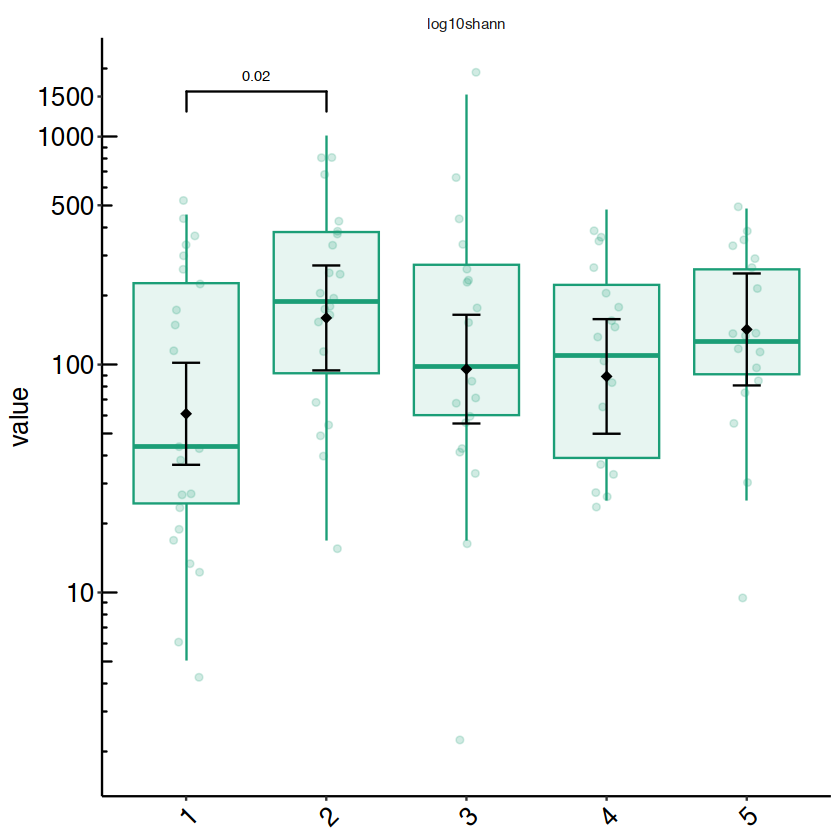

In [29]:
leu_tcr_p

In [30]:
leu_flow_p <- baseplot_lsm_sig( pbmc_flow_m[ pbmc_flow_m$cancergroup == "Leukemia", ], leu_flow, mysig_flow, c(80,90), "flow")
leu_ncr_p <- baseplot_lsm_sig( pbmc_ncr_m[ pbmc_ncr_m$cancergroup == "Leukemia", ], leu_ncr, mysig_ncr, c(80,90), "ncr")

Warning message in geom_signif(data = sig_df, aes(xmin = "1", xmax = Cycle, annotations = p.val, :
“Ignoring unknown aesthetics: xmin, xmax, annotations, and y_position”
Warning message in geom_signif(data = sig_df, aes(xmin = "1", xmax = Cycle, annotations = p.val, :
“Ignoring unknown aesthetics: xmin, xmax, annotations, and y_position”


Warning message:
“Removed 11 rows containing non-finite values (`stat_boxplot()`).”
Warning message:
“Removed 11 rows containing missing values (`geom_point()`).”


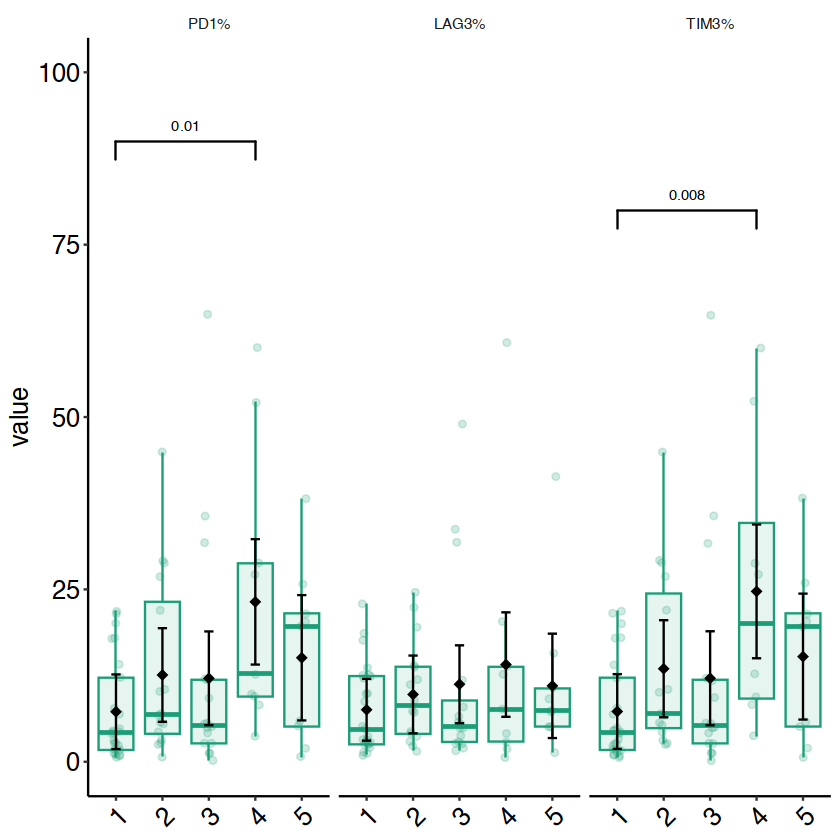

In [31]:
leu_ncr_p

In [32]:
pdf(paste0(plotpath, "p_leu_lsmeans.pdf"), width = 12, height = 3)
cowplot::plot_grid(leu_flow_p + ylab("% T-cell subset"),
    leu_ncr_p + ylab("% Negative Checkpoint Marker"),
    leu_tcr_p + ylab("TCR diversity (log10)"),
    rel_widths = c(0.5, 0.3, 0.2), nrow = 1, ncol = 3
)
dev.off()


Warning message:
“Removed 11 rows containing non-finite values (`stat_boxplot()`).”
Warning message:
“Removed 11 rows containing missing values (`geom_point()`).”


pdf 
  2

In [33]:
tapply(pbmc_flow$`PD1%`[ pbmc_flow$cancergroup == "Leukemia"], pbmc_flow$cycle[ pbmc_flow$cancergroup == "Leukemia"], median, na.rm = TRUE)

X01       X02       X03       X04       X05 
 4.277879  6.895305  5.289740 12.754159 19.620253

Solid

In [58]:
cancergrp <- "Solid tumors"

grp_df <- pbmc_tcr[ pbmc_tcr$cancergroup == cancergrp,]
myformula <- as.formula(paste0( "log10shann", " ~ cycle + Age + (1 | Patient)"))
myfit <- lme4::lmer( myformula, data= grp_df) # keep cycle as categorical
lsm <- lsmeans(myfit, "cycle")
mylsm_grp <- summary(lsm)
mylsm_grp$cancergroup <- cancergrp # has to be same as original df
mylsm_grp$marker <- "log10shann"

myctrt_grp <- as.data.frame(lsmeans::contrast(lsm, "trt.vs.ctrl", ref = "X01"))
myctrt_grp$cancergroup <- cancergrp
myctrt_grp$marker <- "log10shann"

mylsm_grp$Cycle <- as.character(mylsm_grp$cycle)
mylsm_grp$Cycle <- as.numeric(gsub("X0", "", mylsm_grp$Cycle))

myctrt_grp$Cycle <- as.character(gsub(" - X01", "", myctrt_grp$contrast))
myctrt_grp$Cycle <- gsub("X0", "", myctrt_grp$Cycle)

solid_tcr <- list(mylsm_grp, myctrt_grp)

In [59]:
solid_tcr

,cycle,lsmean,SE,df,lower.CL,upper.CL,cancergroup,marker,Cycle
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
1,X01,1.795871,0.1828554,54.85417,1.429398,2.162343,Solid tumors,log10shann,1
2,X02,2.020671,0.1839020,54.95499,1.652116,2.389225,Solid tumors,log10shann,2
3,X03,1.749325,0.1841970,54.89941,1.380171,2.118479,Solid tumors,log10shann,3
4,X04,1.744306,0.2446734,54.45412,1.253859,2.234753,Solid tumors,log10shann,4
5,X05,1.911602,0.2094201,54.97609,1.491911,2.331293,Solid tumors,log10shann,5
,contrast,estimate,SE,df,t.ratio,p.value,cancergroup,marker,Cycle
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>
1,X02 - X01,0.22480024,0.2442802,39.12230,0.9202556,0.7354568,Solid tumors,log10shann,2
2,X03 - X01,-0.04654546,0.2544637,48.12044,-0.1829159,0.9936344,Solid tumors,log10shann,3


In [35]:
solid_flow <- lsmeans_df.fx(pbmc_flow, c("`Naïve%`", "`SCM%`", "`CM%`", "`EM%`", "`TE%`") ,"Solid tumors")
solid_ncr <- lsmeans_df.fx(pbmc_flow, c("`LAG3%`", "`TIM3%`", "`PD1%`") ,"Solid tumors")

[1] "`SCM%`"
[1] "`CM%`"
[1] "`EM%`"


boundary (singular) fit: see help('isSingular')



[1] "`TE%`"
[1] "`TIM3%`"


boundary (singular) fit: see help('isSingular')



[1] "`PD1%`"


boundary (singular) fit: see help('isSingular')



In [36]:
mysig_flow <- solid_flow[[2]]
mysig_flow <- mysig_flow[ mysig_flow$p.value < 0.05,]
mysig_flow$p.val <- sapply(mysig_flow$p.value, function(x) round_and_format(x) )

In [37]:
mysig_ncr <- solid_ncr[[2]]
mysig_ncr <- mysig_ncr[ mysig_ncr$p.value < 0.05,]
mysig_ncr$p.val <- sapply(mysig_ncr$p.value, function(x) round_and_format(x) )

In [38]:
mysig_tcr <- solid_tcr[[2]]
mysig_tcr <- mysig_tcr[ mysig_tcr$p.value < 0.05,]
mysig_tcr$p.val <- sapply(mysig_tcr$p.value, function(x) round_and_format(x) )

In [39]:
mysig_flow

,contrast,estimate,SE,df,t.ratio,p.value,cancergroup,marker,Cycle,p.val
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<fct>,<chr>,<chr>
1,X02 - X01,-14.21873,5.237650,58.82606,-2.714715,0.030972456,Solid tumors,Naïve%,2,0.03
10,X03 - X01,17.63475,4.469504,70.34037,3.945571,0.000720463,Solid tumors,CM%,3,7.2e-04
11,X04 - X01,11.47241,4.479098,69.26191,2.561320,0.044271865,Solid tumors,CM%,4,0.04
12,X05 - X01,14.60150,4.842155,70.11552,3.015496,0.013147621,Solid tumors,CM%,5,0.01


In [40]:
solid_tcr_p <- baseplot_lsm_sig( pbmc_tcr[ pbmc_tcr$cancergroup == "Solid tumors", ], solid_tcr, mysig_tcr, 3.2, "tcr")

Warning message in geom_signif(data = sig_df, aes(xmin = "1", xmax = Cycle, annotations = p.val, :
“Ignoring unknown aesthetics: xmin, xmax, annotations, and y_position”


In [41]:
solid_flow_p <- baseplot_lsm_sig( pbmc_flow_m[ pbmc_flow_m$cancergroup == "Solid tumors", ], solid_flow, mysig_flow, c(100,90, 80, 100), "flow")
solid_ncr_p <- baseplot_lsm_sig( pbmc_ncr_m[ pbmc_ncr_m$cancergroup == "Solid tumors", ], solid_ncr, mysig_ncr, c(70,80,90,100, 60,70,80), "ncr")

Warning message in geom_signif(data = sig_df, aes(xmin = "1", xmax = Cycle, annotations = p.val, :
“Ignoring unknown aesthetics: xmin, xmax, annotations, and y_position”
Warning message in geom_signif(data = sig_df, aes(xmin = "1", xmax = Cycle, annotations = p.val, :
“Ignoring unknown aesthetics: xmin, xmax, annotations, and y_position”


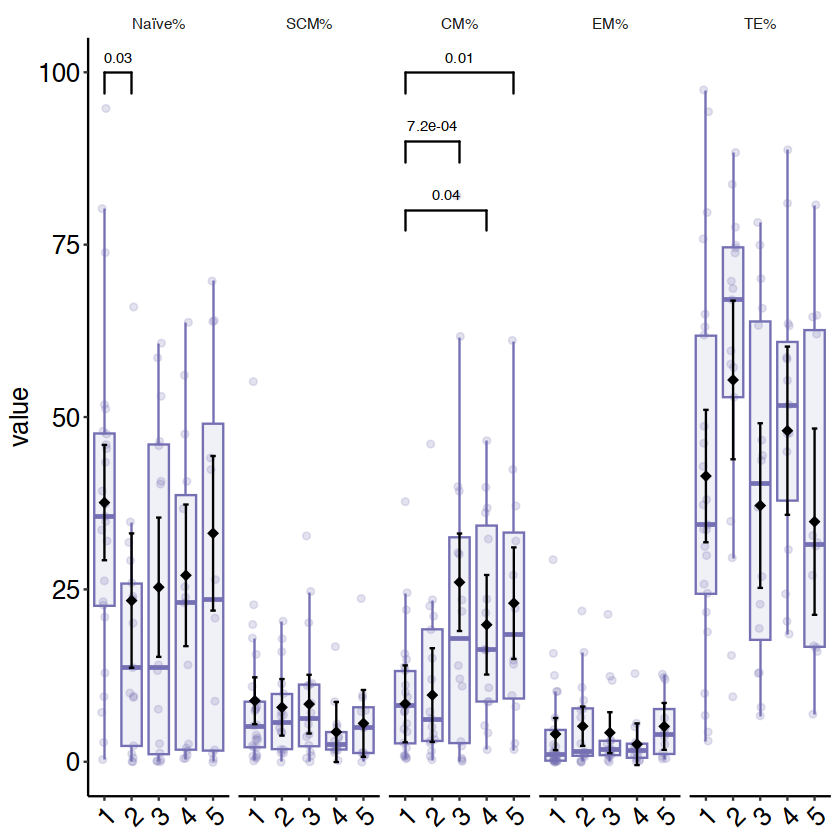

In [42]:
solid_flow_p

In [43]:
pdf(paste0(plotpath, "p_solid_lsmeans.pdf"), width = 12, height = 3)
cowplot::plot_grid(solid_flow_p + ylab("% T-cell subset"),
    solid_ncr_p + ylab("% Negative Checkpoint Marker"),
    solid_tcr_p + ylab("TCR diversity (log10)"),
    rel_widths = c(0.5, 0.3, 0.2), nrow = 1, ncol = 3
)
dev.off()


Warning message:
“Removed 8 rows containing non-finite values (`stat_boxplot()`).”
Warning message:
“Removed 8 rows containing missing values (`geom_point()`).”


pdf 
  2

In [44]:
tapply(pbmc_flow$`PD1%`[ pbmc_flow$cancergroup == "Leukemia"], pbmc_flow$cycle[ pbmc_flow$cancergroup == "Leukemia"], median, na.rm = TRUE)

X01       X02       X03       X04       X05 
 4.277879  6.895305  5.289740 12.754159 19.620253

Lym

In [45]:
cancergrp <- "Lymphoma"

grp_df <- pbmc_tcr[ pbmc_tcr$cancergroup == cancergrp,]
myformula <- as.formula(paste0( "log10shann", " ~ cycle + Age + (1 | Patient)"))
myfit <- lme4::lmer( myformula, data= grp_df) # keep cycle as categorical
lsm <- lsmeans(myfit, "cycle")
mylsm_grp <- summary(lsm)
mylsm_grp$cancergroup <- cancergrp # has to be same as original df
mylsm_grp$marker <- "log10shann"

myctrt_grp <- as.data.frame(lsmeans::contrast(lsm, "trt.vs.ctrl", ref = "X01"))
myctrt_grp$cancergroup <- cancergrp
myctrt_grp$marker <- "log10shann"

mylsm_grp$Cycle <- as.character(mylsm_grp$cycle)
mylsm_grp$Cycle <- as.numeric(gsub("X0", "", mylsm_grp$Cycle))

myctrt_grp$Cycle <- as.character(gsub(" - X01", "", myctrt_grp$contrast))
myctrt_grp$Cycle <- gsub("X0", "", myctrt_grp$Cycle)

lym_tcr <- list(mylsm_grp, myctrt_grp)

boundary (singular) fit: see help('isSingular')



In [46]:
lym_flow <- lsmeans_df.fx(pbmc_flow, c("`Naïve%`", "`SCM%`", "`CM%`", "`EM%`", "`TE%`") ,"Lymphoma")
lym_ncr <- lsmeans_df.fx(pbmc_flow, c("`LAG3%`", "`TIM3%`", "`PD1%`") ,"Lymphoma")

[1] "`SCM%`"
[1] "`CM%`"
[1] "`EM%`"
[1] "`TE%`"
[1] "`TIM3%`"
[1] "`PD1%`"


In [47]:
mysig_flow <- lym_flow[[2]]
mysig_flow <- mysig_flow[ mysig_flow$p.value < 0.05,]
mysig_flow$p.val <- sapply(mysig_flow$p.value, function(x) round_and_format(x) )

In [48]:
mysig_ncr <- lym_ncr[[2]]
mysig_ncr <- mysig_ncr[ mysig_ncr$p.value < 0.05,]
mysig_ncr$p.val <- sapply(mysig_ncr$p.value, function(x) round_and_format(x) )

In [49]:
mysig_tcr <- lym_tcr[[2]]
mysig_tcr <- mysig_tcr[ mysig_tcr$p.value < 0.05,]
mysig_tcr$p.val <- sapply(mysig_tcr$p.value, function(x) round_and_format(x) )

In [57]:
mysig_tcr

contrast,estimate,SE,df,t.ratio,p.value,cancergroup,marker,Cycle,p.val
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<list>


In [51]:
lym_tcr_p <- baseplot_lsm_sig( pbmc_tcr[ pbmc_tcr$cancergroup == "Lymphoma", ], lym_tcr, mysig_tcr, 3.2, "tcr")

Warning message in geom_signif(data = sig_df, aes(xmin = "1", xmax = Cycle, annotations = p.val, :
“Ignoring unknown aesthetics: xmin, xmax, annotations, and y_position”


In [52]:
lym_flow_p <- baseplot_lsm_sig( pbmc_flow_m[ pbmc_flow_m$cancergroup == "Lymphoma", ], lym_flow, mysig_flow, c(70,80, 90, 100, 100), "flow")
lym_ncr_p <- baseplot_lsm_sig( pbmc_ncr_m[ pbmc_ncr_m$cancergroup == "Lymphoma", ], lym_ncr, mysig_ncr, c(70), "ncr")

Warning message in geom_signif(data = sig_df, aes(xmin = "1", xmax = Cycle, annotations = p.val, :
“Ignoring unknown aesthetics: xmin, xmax, annotations, and y_position”
Warning message in geom_signif(data = sig_df, aes(xmin = "1", xmax = Cycle, annotations = p.val, :
“Ignoring unknown aesthetics: xmin, xmax, annotations, and y_position”


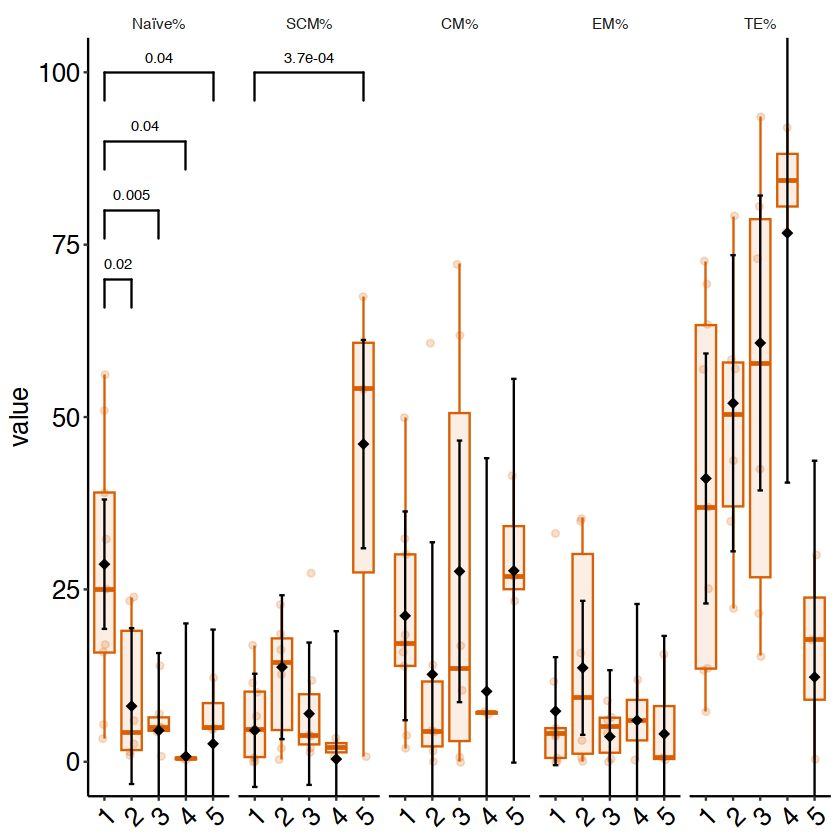

In [53]:
lym_flow_p

In [54]:
pdf(paste0(plotpath, "p_lym_lsmeans.pdf"), width = 12, height = 3)
cowplot::plot_grid(lym_flow_p + ylab("% T-cell subset"),
    lym_ncr_p + ylab("% Negative Checkpoint Marker"),
    lym_tcr_p + ylab("TCR diversity (log10)"),
    rel_widths = c(0.5, 0.3, 0.2), nrow = 1, ncol = 3
)
dev.off()


Warning message:
“Removed 3 rows containing non-finite values (`stat_boxplot()`).”
Warning message:
“Removed 3 rows containing missing values (`geom_point()`).”


pdf 
  2

In [55]:
tapply(pbmc_flow$`PD1%`[ pbmc_flow$cancergroup == "Leukemia"], pbmc_flow$cycle[ pbmc_flow$cancergroup == "Leukemia"], median, na.rm = TRUE)

X01       X02       X03       X04       X05 
 4.277879  6.895305  5.289740 12.754159 19.620253

# Backup

## over time comparisons

In [56]:
p1 <- baseplot_smooth.fx(mydf = pbmc_flow, x = "Cycle", y = "`Naïve%`", fill = "cancergroup", clr = "cancergroup", colpal = group_col)

ERROR: Error in baseplot_smooth.fx(mydf = pbmc_flow, x = "Cycle", y = "`Naïve%`", : could not find function "baseplot_smooth.fx"


In [ ]:
p1

In [ ]:
p2 <- baseplot_smooth.fx(mydf = pbmc_flow, x = "Cycle", y = "`SCM%`", fill = "cancergroup", clr = "cancergroup", colpal = group_col)
p3 <- baseplot_smooth.fx(mydf = pbmc_flow, x = "Cycle", y = "`CM%`", fill = "cancergroup", clr = "cancergroup", colpal = group_col)
p4 <- baseplot_smooth.fx(mydf = pbmc_flow, x = "Cycle", y = "`EM%`", fill = "cancergroup", clr = "cancergroup", colpal = group_col)
p5 <- baseplot_smooth.fx(mydf = pbmc_flow, x = "Cycle", y = "`TE%`", fill = "cancergroup", clr = "cancergroup", colpal = group_col)
p6 <- baseplot_smooth.fx(mydf = pbmc_flow, x = "Cycle", y = "`PD1%`", fill = "cancergroup", clr = "cancergroup", colpal = group_col)
p7 <- baseplot_smooth.fx(mydf = pbmc_flow, x = "Cycle", y = "`LAG3%`", fill = "cancergroup", clr = "cancergroup", colpal = group_col)

In [ ]:
p8 <- baseplot_smooth.fx(mydf = pbmc_tcr, x = "Cycle", y = "log10shann", fill = "cancergroup", clr = "cancergroup", colpal = group_col)

In [ ]:
# pdf(paste0(plotpath, "overtime_pbmc.pdf"), width = 8, height = 12)
# cowplot::plot_grid(p1, p2, p3, p4, p5, p6, p7,p8, nrow = 5)
# dev.off()

In [ ]:
p1 <- baseraincloud_plot.fx(pbmc_solid, "`Naïve%`", "cycle", "cancergroup", group_col, 0.5, 2)  

In [ ]:
mytest <- "Naïve%"
mypval1 <- ks.test(pbmc_solid[[mytest]][ which(pbmc_solid$cycle == "X01")], pbmc_solid[[mytest]][ which(pbmc_solid$cycle == "X02")])$p.value

In [ ]:
mypval1 <- formatC(mypval1, format = "e", digits = 2)

In [ ]:
p1_stat <- p1 + geom_signif(
    y_position = 100, xmin = 1, xmax = 2,
    annotation = paste0("p = ",mypval1), tip_length = 0.01, textsize = 5
  ) + theme(axis.text.x = element_blank()) + ggtitle(expression(underline("Solid tumors") ))

In [ ]:
p2 <- baseraincloud_plot.fx(pbmc_solid, "`TE%`", "cycle", "cancergroup", group_col, 0.5, 2)  

In [ ]:
p2

In [ ]:
mytest <- "TE%"
mypval2 <- ks.test(pbmc_solid[[mytest]][ which(pbmc_solid$cycle == "X01")], pbmc_solid[[mytest]][ which(pbmc_solid$cycle == "X02")])$p.value
mypval2 <- formatC(mypval2, format = "e", digits = 2)

In [ ]:
p2_stat <- p2 + geom_signif(
    y_position = 100, xmin = 1, xmax = 2,
    annotation = paste0("p = ",mypval2), tip_length = 0.01, textsize = 5
  ) 

In [ ]:
p2_stat

In [ ]:
p3 <- baseraincloud_plot.fx(pbmc_solid, "`PD1%`", "cycle", "cancergroup", group_col, 0.5, 2)  

In [ ]:
mytest <- "PD1%"
mypval3 <- ks.test(pbmc_solid[[mytest]][ which(pbmc_solid$cycle == "X01")], pbmc_solid[[mytest]][ which(pbmc_solid$cycle == "X03")])$p.value
mypval4 <- ks.test(pbmc_solid[[mytest]][ which(pbmc_solid$cycle == "X01")], pbmc_solid[[mytest]][ which(pbmc_solid$cycle == "X04")])$p.value
mypval5 <- ks.test(pbmc_solid[[mytest]][ which(pbmc_solid$cycle == "X01")], pbmc_solid[[mytest]][ which(pbmc_solid$cycle == "X05")])$p.value

In [ ]:
mypval3 <- formatC(mypval3, format = "e", digits = 2)
mypval4 <- formatC(mypval4, format = "e", digits = 2)
mypval5 <- formatC(mypval5, format = "e", digits = 2)

In [ ]:
p3_stat <- p3 + geom_signif(
    y_position = c(50,60,70), xmin = c(1,1,1), xmax = c(3,4,5),
    annotation = c(paste0("p = ",mypval3), paste0("p = ",mypval4), paste0("p = ",mypval5) ) , tip_length = 0.01, textsize = 5
  ) 

In [ ]:
p4 <- baseraincloud_plot.fx(pbmc_solid, "`LAG3%`", "cycle", "cancergroup", group_col, 0.5, 2)  

In [ ]:
mytest <- "LAG3%"
mypval6 <- ks.test(pbmc_solid[[mytest]][ which(pbmc_solid$cycle == "X01")], pbmc_solid[[mytest]][ which(pbmc_solid$cycle == "X04")])$p.value

In [ ]:
mypval6 <- formatC(mypval6, format = "e", digits = 2)

In [ ]:
p4_stat <- p4 + geom_signif(
    y_position = 80, xmin = 1, xmax = 4,
    annotation = paste0("p = ",mypval3) , tip_length = 0.01, textsize = 5
  ) 

In [ ]:
p4_stat

In [ ]:
pdf(paste0(plotpath, "rainclouds_naive_te_pd1_lag3_solid.pdf"), width = 4, height = 10)
plot_grid(p1_stat, p2_stat, p3_stat, p4_stat, nrow = 4, align = "v", axis = "lr")
dev.off()

In [ ]:
# remove p1 p2 p3 p4 p1_stat p2_stat p3_stat p4_stat
rm(p1, p2, p3, p4, p1_stat, p2_stat, p3_stat, p4_stat)

Leukemias

In [ ]:
pbmc_leu <- pbmc[ which(pbmc$cancergroup == "Leukemia"),]

In [ ]:
p1 <- baseraincloud_plot.fx(pbmc_leu, "`CM%`", "cycle", "cancergroup", group_col, 0.5, 2)  

In [ ]:
p1

In [ ]:
mytest <- "CM%"
mypval1 <- ks.test(pbmc_leu[[mytest]][ which(pbmc_leu$cycle == "X01")], pbmc_leu[[mytest]][ which(pbmc_leu$cycle == "X03")])$p.value

In [ ]:
mypval1 <- formatC(mypval1, format = "e", digits = 2)

In [ ]:
p1_stat <- p1 + geom_signif(
    y_position = 100, xmin = 1, xmax = 3,
    annotation = paste0("p = ",mypval1), tip_length = 0.01, textsize = 5
  ) + theme(axis.text.x = element_blank()) + ggtitle(expression(underline("Leukemia") ))

In [ ]:
p1_stat

In [ ]:
p2 <- baseraincloud_plot.fx(pbmc_leu, "`TE%`", "cycle", "cancergroup", group_col, 0.5, 2)  

In [ ]:
p2

In [ ]:
mytest <- "TE%"
mypval2 <- ks.test(pbmc_leu[[mytest]][ which(pbmc_leu$cycle == "X01")], pbmc_leu[[mytest]][ which(pbmc_leu$cycle == "X04")])$p.value
mypval2 <- formatC(mypval2, format = "e", digits = 2)

In [ ]:
p2_stat <- p2 + geom_signif(
    y_position = 100, xmin = 1, xmax = 4,
    annotation = paste0("p = ",mypval2), tip_length = 0.01, textsize = 5
  ) 

In [ ]:
p2_stat

In [ ]:
p3 <- baseraincloud_plot.fx(pbmc_leu, "`PD1%`", "cycle", "cancergroup", group_col, 0.5, 2)  

In [ ]:
mytest <- "PD1%"
mypval3 <- ks.test(pbmc_leu[[mytest]][ which(pbmc_leu$cycle == "X01")], pbmc_leu[[mytest]][ which(pbmc_leu$cycle == "X04")])$p.value
mypval3 <- formatC(mypval3, format = "e", digits = 2)

In [ ]:
mypval3

In [ ]:
p3_stat <- p3 + geom_signif(
    y_position = 100, xmin = 1, xmax = 4,
    annotation = paste0("p = ",mypval3), tip_length = 0.01, textsize = 5
  ) 

In [ ]:
p4 <- baseraincloud_plot.fx(pbmc_leu, "`LAG3%`", "cycle", "cancergroup", group_col, 0.5, 2)  

In [ ]:
p4

In [ ]:
mytest <- "LAG3%"
mypval4 <- ks.test(pbmc_leu[[mytest]][ which(pbmc_leu$cycle == "X01")], pbmc_leu[[mytest]][ which(pbmc_leu$cycle == "X05")])$p.value
mypval4 <- formatC(mypval4, format = "e", digits = 2)

In [ ]:
p4_stat <- p4 + geom_signif(
    y_position = 100, xmin = 1, xmax = 4,
    annotation = paste0("p = ",mypval4), tip_length = 0.01, textsize = 5
  ) 

In [ ]:
pdf(paste0(plotpath, "rainclouds_naive_te_pd1_lag3_leukemia.pdf"), width = 4, height = 10)
plot_grid(p1_stat, p2_stat,p3_stat, p4_stat, nrow = 4, align = "v", axis = "lr")
dev.off()